# Recherche modèles de prédiction en séquences

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from datetime import datetime

2024-02-21 07:51:19.403185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Extrait les dernières données et écrit le dataset

In [2]:
from lib.dataeng import Etl

In [3]:
etl = Etl()

df_weight_raw, df_food_raw, df_exos_raw, df_all = etl.extract_store_all()


Le fichier poids le plus récent est : data_BEN_1708497738.zip, parmi :
data_BEN_1708497738.zip
data_BEN_1708405395.zip
data_BEN_1708327447.zip
data_BEN_1708234834.zip

Le fichier food le plus récent est : File-Export-2020-08-03-to-2024-02-21.zip, parmi
File-Export-2020-08-03-to-2024-02-21.zip
File-Export-2020-08-03-to-2024-02-18.zip
File-Export-2020-08-03-to-2024-02-19.zip
File-Export-2020-08-03-to-2024-02-20.zip

Le fichier exercices le plus récent est : polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip, parmi :
polar-user-data-export_12baa4ce-79a5-40f8-ad40-74308f7c2c26.zip
polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip


100%|██████████| 1868/1868 [01:14<00:00, 25.10it/s]


In [4]:
fullds_path = '/home/benjamin/Folders_Python/Weight/data/full_dataset.csv'

with open(fullds_path, 'r') as f:
    df_full = pd.read_csv(f, index_col=0)
    
cols_to_drop = ['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']
df_full.drop(columns=cols_to_drop, inplace=True)
df_full.dropna(inplace=True)

In [5]:
df_full.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Masse_Totale,1274.0,73.731590,7.714160,66.000000,69.282917,71.385238,73.338125,107.250000
Masse_Grasse,1274.0,12.191102,5.120339,7.541667,8.960000,10.884444,12.187167,37.190000
MG%,1274.0,0.160899,0.043613,0.112927,0.129014,0.151813,0.167542,0.346760
BMR,1274.0,1699.274542,58.858471,1626.348571,1664.393500,1679.419000,1705.852000,1933.516000
Calories,1274.0,1966.052119,456.549835,0.300000,1779.125000,1849.750000,2037.675000,5762.000000
Lipides,1274.0,52.774882,22.338108,0.000000,38.525000,49.300000,63.900000,235.900000
Glucides,1274.0,212.606750,75.455134,0.100000,168.175000,198.400000,240.550000,875.400000
Proteines,1274.0,157.389874,39.831366,0.000000,134.400000,162.500000,184.675000,267.100000
exo_duree,1274.0,2721.076118,2815.196791,0.000000,0.000000,2400.000000,4758.561000,28800.000000
exo_cals_bruts,1274.0,296.176609,294.505413,0.000000,0.000000,277.500000,496.500000,2290.000000


In [6]:
ds = df_full[['Calories', 'exo_cals_nets', 'Masse_Totale', 'Masse_Grasse']]

In [7]:
ds

,Calories,exo_cals_nets,Masse_Totale,Masse_Grasse
2020-08-09,1861.3,0.000000,107.250000,37.190000
2020-08-11,1772.4,0.000000,104.650000,33.150000
2020-08-12,1894.3,0.000000,104.350000,33.800000
2020-08-13,1822.6,0.000000,104.400000,34.340000
2020-08-14,1891.5,0.000000,104.500000,33.850000
...,...,...,...,...
2024-02-16,1884.3,587.565919,73.769333,12.443333
2024-02-17,2364.3,208.780068,74.114000,12.265333
2024-02-18,1711.0,341.943103,74.788125,12.853125
2024-02-19,1712.7,230.485734,74.280000,12.382000


### Dates cut off

In [8]:
datetime.strptime(ds.index[0], "%Y-%m-%d")

CUT_OFF = datetime(2021,7,1)
ds['Date'] = [ datetime.strptime(ds.index[i],'%Y-%m-%d') for i in range(len(ds)) ]

ds = ds[ds['Date'] >= CUT_OFF]

ds.drop(columns=['Date'], inplace=True)

/tmp/ipykernel_10088/3298968531.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['Date'] = [ datetime.strptime(ds.index[i],'%Y-%m-%d') for i in range(len(ds)) ]
/tmp/ipykernel_10088/3298968531.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.drop(columns=['Date'], inplace=True)


In [9]:
ds

,Calories,exo_cals_nets,Masse_Totale,Masse_Grasse
2021-07-01,1852.7,0.000000,71.516667,10.820000
2021-07-02,1961.0,582.881674,71.100000,10.856667
2021-07-03,1852.2,0.000000,70.650000,10.453333
2021-07-04,2072.6,797.020362,70.033333,10.446667
2021-07-05,1903.7,0.000000,70.283333,10.460000
...,...,...,...,...
2024-02-16,1884.3,587.565919,73.769333,12.443333
2024-02-17,2364.3,208.780068,74.114000,12.265333
2024-02-18,1711.0,341.943103,74.788125,12.853125
2024-02-19,1712.7,230.485734,74.280000,12.382000


In [10]:
# from lib.librnn import CreateDataset  # utilisation de tf.dataset : compliqué
# essai = CreateDataset(ds)
# essai.dataframe.head(20)

# dsf = essai.create_dataset()

### création dataset

On créé un dataset pour des modèles de sequence-to-sequence.

Hyperparamètres :
- PAST = longueur (en jours) de l'historique que l'on va prendre en entrée. Détermine la longueur de la séquence en entrée.
- FUTURE = longueur (en jours) de la fenêtre sur laquelle on veut prédire. Longueur de la séquence en sortie

Description :
- INPUTS : au timestep d'indice i, c'est une séquence (vecteur) concaténation de:
  - la séquence de longueur PAST, indices de i-PAST+1 à i (inclus) des features exo_cals_nets, Calories, Masse_Totale, Masse_Grasse
  - la séquence de longueur FUTURE, indices de i+1 à i+FUTURE (inclus) des features exo_cals_nets, Calories
- OUTPUTS : les valeurs cibles au timestep d'indce sont une séquence (vecteur):
  - séquence de longueur FUTURE, formée des indices i+1 à i+FUTURE des valeurs Masse_Totale, Masse_Grasse

Le modèle vont apprendre sur des séquences formées de tous les inputs passés (calories exercices, food, masses) et des inputs prévus dans le futur (calories exercices et food) pour prévoir les masses dans le futur

In [11]:
class CreateDataset2():
    
    # default values
    PAST = 2
    FUTURE = 1
    
    def __init__(self, dataframe,  past=None, future=None):
        """Créé le dataset avec paramètres : 
        <past> est le nombre de jours de données passées : calories food, exercices, masses totale grasse
        <futur> est le nombre de jours où l'on veut prédire masse totale et masse grasse
        Les inputs sont formés de (calories_food, calories_exercices, masse_totale, masse_grasse) sur toute la durée past 
        ET les données (calories_food, calories_exercices) sur la période de <futur - 1> jours.
        les outputs sont les (masse_totale, masse_grasse) sur le futur

        Args:
            dataframe (pd.Dataframe): dataframe des données d'entrée. Index formé de datetimes. Colonnes : 'exo_cals_nets', 'Calories', 'Masse_Totale', 'Masse_Grasse'
            past (int, optional): nombre de jours dans le passé. Defaults to None.
            future (int, optional): nombre de jours dans le futur pour la prévision. Defaults to None
        """
        
        self.data = dataframe
        self.past = self.PAST if past is None else past
        self.future = self.FUTURE if future is None else future
        
    def create_dataset(self):
        """construit et retourne le dataset
        """
        id_start = self.past - 1  # plus petit indice à paritr duquel on peut itérer la construction = indice rang de départ
        id_stop = len(self.data) - self.future - 1 # indice max : plus grand indice jusqu'au quel on peut itérer
        
        n_timesteps = id_stop - id_start
        n_features = self.past * 4 + (self.future - 1) * 2 # dimension du vecteur input à chaque timestep
        output_dim = self.future * 2 # dimension vecteur sortie
        
        inputs = np.zeros(shape=(n_timesteps, n_features))  # la sortie sera un np.array de shape n_timesteps
        outputs = np.zeros(shape=(n_timesteps, output_dim))
        
        for i in range(id_start, id_stop):
            # print(id_start, id_stop, i, i-self.past, i+1, i+self.future +1)
            x1 = self.data.iloc[i-self.past+1:i+1,:].to_numpy().flatten()
            # print(x1.shape)
            x2 = self.data.iloc[i+1:i+self.future,:2].to_numpy().flatten()
            # print(x2.shape)
            x = np.concatenate([x1, x2])
            inputs[i-id_start] = x
            # print(self.data.iloc[i+1:i+self.future+2,-2:].to_numpy().flatten())
            outputs[i-id_start] = self.data.iloc[i+1:i+self.future+1,-2:].to_numpy().flatten()
            
        df = pd.DataFrame(data = np.concatenate((inputs, outputs), axis=1), index=ds.index[self.past:-self.future])
        
        columns_names = [ f'input_{i}' for i in range(inputs.shape[1]) ] + [ f'outputs_{i}' for i in range(outputs.shape[1]) ]
        # print(columns_names)
        df.columns = columns_names
            
        return inputs, outputs, df
    
    def __repr__(self) -> str:
        output = f'dataset longueur {len(self.data)} jours\n' + f'de {self.data.index[0]} à {self.data.index[-1]}\n' \
            + f'PAST = {self.past}, FUTUR = {self.future}'
        return output

In [12]:
e = CreateDataset2(ds, past=3, future=2)

In [13]:
e

dataset longueur 958 jours
de 2021-07-01 à 2024-02-20
PAST = 3, FUTUR = 2

In [14]:
inputs, outputs, df = e.create_dataset()

In [15]:
ds.tail(12)

,Calories,exo_cals_nets,Masse_Totale,Masse_Grasse
2024-02-09,1687.3,209.483420,72.121333,12.070000
2024-02-10,2370.6,345.293552,72.171333,12.149333
2024-02-11,1794.8,415.607489,72.368000,12.071333
2024-02-12,2687.5,414.377460,73.057333,12.326667
2024-02-13,1274.3,70.772639,73.218000,12.408000
2024-02-14,1947.7,135.592919,73.686000,12.185333
2024-02-15,1704.8,294.989476,74.404667,11.867333
2024-02-16,1884.3,587.565919,73.769333,12.443333
2024-02-17,2364.3,208.780068,74.114000,12.265333
2024-02-18,1711.0,341.943103,74.788125,12.853125


In [16]:
df.tail(20)

,input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13,outputs_0,outputs_1,outputs_2,outputs_3
2024-01-30,1775.9,300.393829,73.350000,12.182857,1821.9,294.128988,73.339167,12.444167,1795.7,181.483944,73.896667,12.780000,1680.9,0.000000,73.340000,12.521538,73.571538,12.973077
2024-01-31,1821.9,294.128988,73.339167,12.444167,1795.7,181.483944,73.896667,12.780000,1680.9,0.000000,73.340000,12.521538,1682.0,332.372089,73.571538,12.973077,73.963333,12.926667
2024-02-01,1795.7,181.483944,73.896667,12.780000,1680.9,0.000000,73.340000,12.521538,1682.0,332.372089,73.571538,12.973077,1664.6,160.687639,73.963333,12.926667,72.486000,12.187333
2024-02-02,1680.9,0.000000,73.340000,12.521538,1682.0,332.372089,73.571538,12.973077,1664.6,160.687639,73.963333,12.926667,1712.0,314.605929,72.486000,12.187333,72.394286,12.155000
2024-02-03,1682.0,332.372089,73.571538,12.973077,1664.6,160.687639,73.963333,12.926667,1712.0,314.605929,72.486000,12.187333,1830.5,263.491712,72.394286,12.155000,72.766667,12.566667
2024-02-04,1664.6,160.687639,73.963333,12.926667,1712.0,314.605929,72.486000,12.187333,1830.5,263.491712,72.394286,12.155000,1746.8,468.083444,72.766667,12.566667,72.806000,12.340000
2024-02-05,1712.0,314.605929,72.486000,12.187333,1830.5,263.491712,72.394286,12.155000,1746.8,468.083444,72.766667,12.566667,1709.9,0.000000,72.806000,12.340000,73.715333,12.574000
2024-02-06,1830.5,263.491712,72.394286,12.155000,1746.8,468.083444,72.766667,12.566667,1709.9,0.000000,72.806000,12.340000,1737.7,335.689293,73.715333,12.574000,73.004667,11.967333
2024-02-07,1746.8,468.083444,72.766667,12.566667,1709.9,0.000000,72.806000,12.340000,1737.7,335.689293,73.715333,12.574000,1851.8,295.374778,73.004667,11.967333,72.600000,12.451875
2024-02-08,1709.9,0.000000,72.806000,12.340000,1737.7,335.689293,73.715333,12.574000,1851.8,295.374778,73.004667,11.967333,1613.4,0.000000,72.600000,12.451875,72.121333,12.070000


# Modèles pour J+1

In [17]:
e = CreateDataset2(ds, past=15, future=1)  # future = 1 day, pour commencer

print(e)

inputs, outputs, df = e.create_dataset()

dataset longueur 958 jours
de 2021-07-01 à 2024-02-20
PAST = 15, FUTUR = 1


In [18]:
df.tail(10)

,input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,...,input_52,input_53,input_54,input_55,input_56,input_57,input_58,input_59,outputs_0,outputs_1
2024-02-10,1778.6,226.307982,73.905833,12.539167,1775.9,300.393829,73.350000,12.182857,1821.9,294.128988,...,1613.4,0.000000,72.600000,12.451875,1687.3,209.483420,72.121333,12.070000,72.171333,12.149333
2024-02-11,1775.9,300.393829,73.350000,12.182857,1821.9,294.128988,73.339167,12.444167,1795.7,181.483944,...,1687.3,209.483420,72.121333,12.070000,2370.6,345.293552,72.171333,12.149333,72.368000,12.071333
2024-02-12,1821.9,294.128988,73.339167,12.444167,1795.7,181.483944,73.896667,12.780000,1680.9,0.000000,...,2370.6,345.293552,72.171333,12.149333,1794.8,415.607489,72.368000,12.071333,73.057333,12.326667
2024-02-13,1795.7,181.483944,73.896667,12.780000,1680.9,0.000000,73.340000,12.521538,1682.0,332.372089,...,1794.8,415.607489,72.368000,12.071333,2687.5,414.377460,73.057333,12.326667,73.218000,12.408000
2024-02-14,1680.9,0.000000,73.340000,12.521538,1682.0,332.372089,73.571538,12.973077,1664.6,160.687639,...,2687.5,414.377460,73.057333,12.326667,1274.3,70.772639,73.218000,12.408000,73.686000,12.185333
2024-02-15,1682.0,332.372089,73.571538,12.973077,1664.6,160.687639,73.963333,12.926667,1712.0,314.605929,...,1274.3,70.772639,73.218000,12.408000,1947.7,135.592919,73.686000,12.185333,74.404667,11.867333
2024-02-16,1664.6,160.687639,73.963333,12.926667,1712.0,314.605929,72.486000,12.187333,1830.5,263.491712,...,1947.7,135.592919,73.686000,12.185333,1704.8,294.989476,74.404667,11.867333,73.769333,12.443333
2024-02-17,1712.0,314.605929,72.486000,12.187333,1830.5,263.491712,72.394286,12.155000,1746.8,468.083444,...,1704.8,294.989476,74.404667,11.867333,1884.3,587.565919,73.769333,12.443333,74.114000,12.265333
2024-02-18,1830.5,263.491712,72.394286,12.155000,1746.8,468.083444,72.766667,12.566667,1709.9,0.000000,...,1884.3,587.565919,73.769333,12.443333,2364.3,208.780068,74.114000,12.265333,74.788125,12.853125
2024-02-19,1746.8,468.083444,72.766667,12.566667,1709.9,0.000000,72.806000,12.340000,1737.7,335.689293,...,2364.3,208.780068,74.114000,12.265333,1711.0,341.943103,74.788125,12.853125,74.280000,12.382000


In [19]:
# basic test train split

cols_X = [ n for n in df.columns if n[:5]=="input" ]
cols_y = [ n for n in df.columns if n[:6]=="output" ]
X = df[cols_X]
y = df[cols_y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [20]:
X_test.head(5)

,input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,...,input_50,input_51,input_52,input_53,input_54,input_55,input_56,input_57,input_58,input_59
2022-06-21,1794.5,217.277150,69.558333,8.638333,1760.7,186.397753,68.546429,8.595000,3890.6,672.522878,...,69.368750,8.926250,2068.6,584.877435,69.503846,8.833077,1884.7,408.347785,69.266667,8.650
2023-02-27,2016.9,236.873483,72.575000,11.285000,1723.8,462.946146,72.914286,11.880000,3491.4,274.727807,...,70.775000,11.026250,2880.8,386.718638,71.380000,10.820000,2019.3,0.000000,72.360000,10.880
2023-11-21,528.5,84.384693,72.585556,12.208889,1265.9,376.626148,71.396250,11.420000,1882.4,240.356853,...,70.686667,10.971111,2187.5,0.000000,70.372000,10.835000,1781.9,254.085925,70.570000,11.134
2022-07-29,2413.8,290.893779,70.311111,9.233333,1711.8,0.000000,71.408333,9.783333,1917.2,334.077231,...,68.915000,9.124000,1783.9,347.063809,68.972727,8.930000,1868.8,345.002108,68.910000,9.130
2021-08-19,1800.6,381.785173,68.383333,8.650000,1803.7,0.000000,68.350000,8.870000,1888.3,604.258377,...,69.087500,8.800000,1802.1,0.000000,68.800000,8.700000,1802.3,0.000000,69.666667,8.920


In [21]:
y_test.head(5)

,outputs_0,outputs_1
2022-06-21,69.622727,8.882727
2023-02-27,72.750000,11.783333
2023-11-21,70.613750,11.318750
2022-07-29,68.470000,8.816000
2021-08-19,69.550000,8.910000


### baseline : prédiction à J+1 = valeurs à J

In [22]:
# sur X_test

y_pred = X_test.iloc[:,-2:]

In [23]:
def evaluate(y_pred, y_test, titre):
    """utility function pour calculer MSE et afficher"""
    mse = tf.keras.losses.MeanSquaredError()
    erreur = mse(y_test, y_pred).numpy()
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

    ax[0].scatter(y_pred.iloc[:,0], y_test.iloc[:,0], label='Masse Totale (pred v truth)')
    ax[0].plot([60,110],[60,110], marker='.', color='green', label='pred=truth')
    ax[0].grid(True)
    ax[0].legend()
    ax[0].set_xlabel('prediction')
    ax[0].set_ylabel('ground truth')

    ax[1].scatter(y_pred.iloc[:,1], y_test.iloc[:,1], label='Masse Grasse (pred v truth)')
    ax[1].plot([8,35],[8,35], marker='.', color='green', label='pred=truth')
    ax[1].grid(True)
    ax[1].legend()
    ax[1].set_xlabel('prediction')
    ax[1].set_ylabel('ground truth')

    title = titre + f'MSE (test set)= {erreur:.3f}'
    fig.suptitle(title)
    
    return erreur, fig, ax


2024-02-21 07:53:05.895530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 07:53:05.906809: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


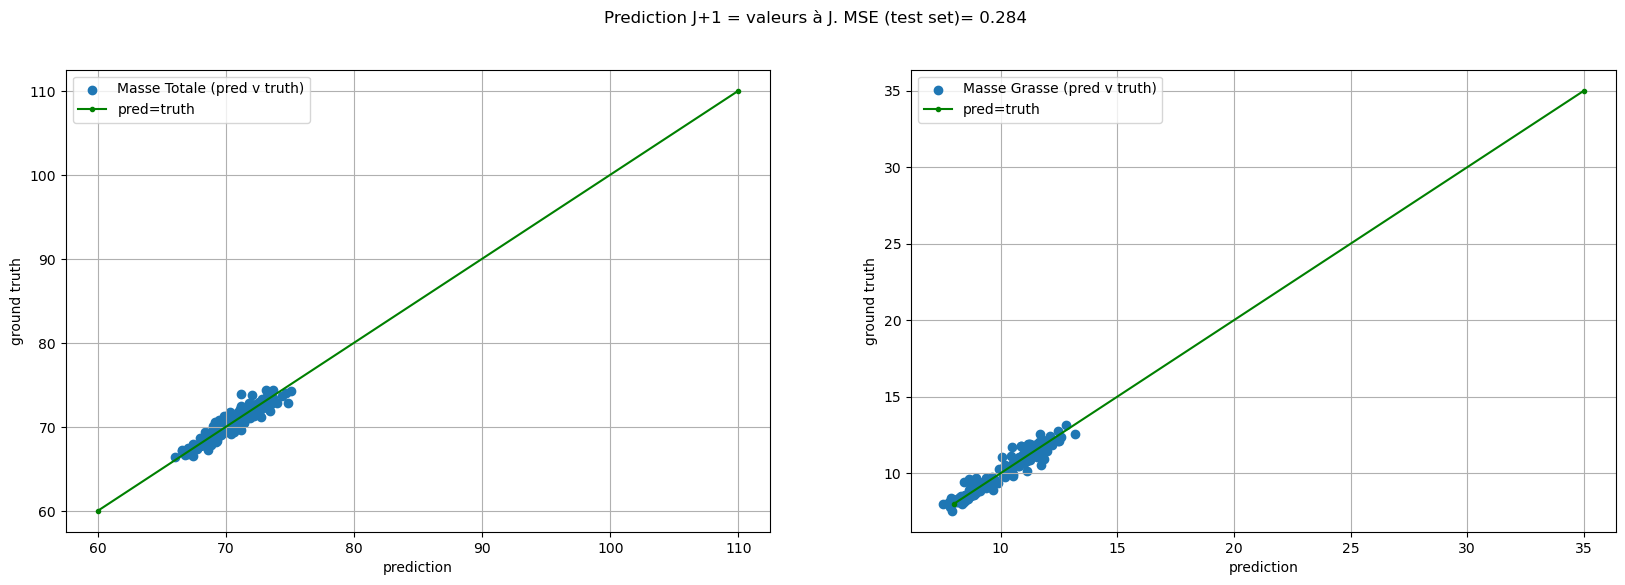

In [24]:
erreur, fig, ax = evaluate(y_pred, y_test, 'Prediction J+1 = valeurs à J. ')

### Regression Linéaire

In [25]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [26]:
y_pred = pd.DataFrame(lr.predict(X_test))

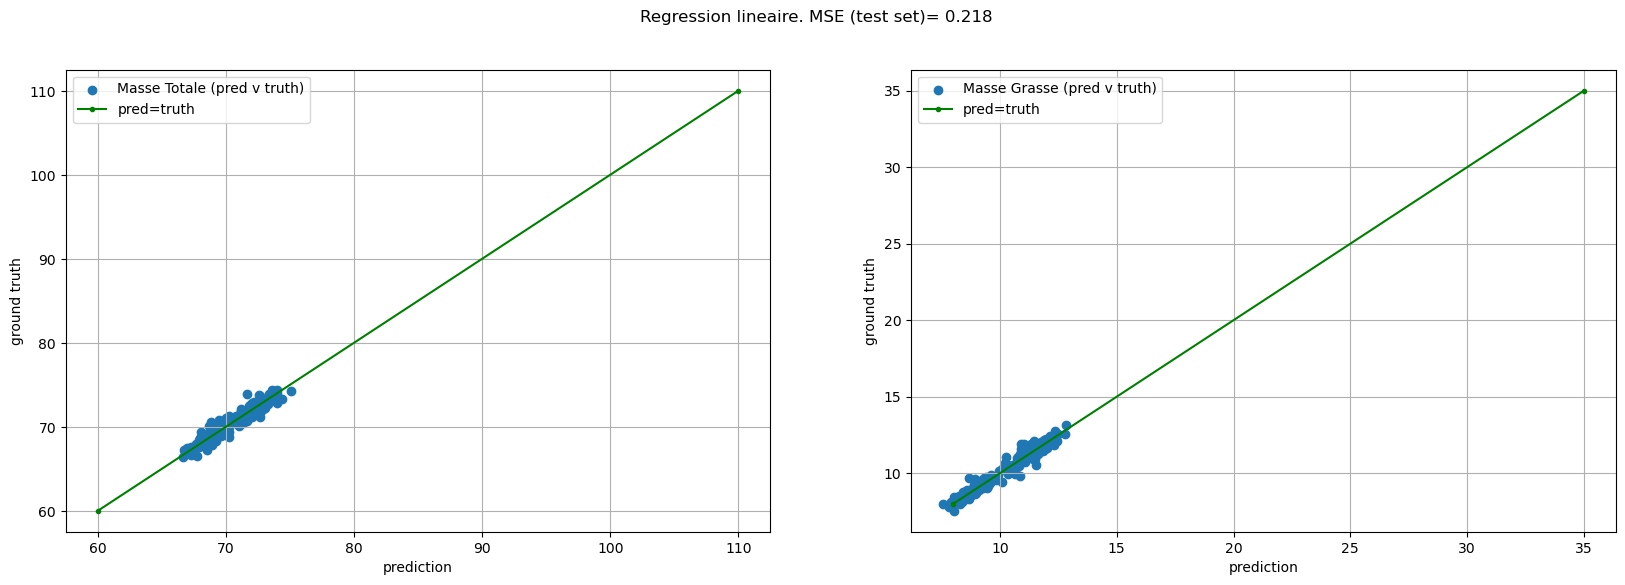

In [27]:
erreur, fig, ax = evaluate(y_pred, y_test, 'Regression lineaire. ')

### MLP simple

In [28]:
n_features = X_train.shape[1]
n_outputs = y_train.shape[1]

n_units = 256

In [29]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [30]:
mlp = tf.keras.models.Sequential(
    [ tf.keras.layers.Input(shape=(n_features,)),
     tf.keras.layers.Dense(units=n_units, activation='relu'),
     tf.keras.layers.Dense(units=n_units, activation='relu'),
     tf.keras.layers.Dense(units=n_units, activation='relu'),
     tf.keras.layers.Dense(units=n_outputs, activation='linear')]
)

In [31]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               15616     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 147,714
Trainable params: 147,714
Non-trainable params: 0
_________________________________________________________________


In [32]:
mlp.compile(
    optimizer='rmsprop',
    loss = tf.keras.losses.MeanSquaredError()
)

cb1 = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)

In [33]:
history = mlp.fit(
    X_train_scaled, y_train_scaled,
    epochs=1000,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks = [cb1]
)

Epoch 1/1000
24/24 [==============================] - 6s 105ms/step - loss: 0.2358 - val_loss: 0.1356
Epoch 2/1000
24/24 [==============================] - 2s 69ms/step - loss: 0.1131 - val_loss: 0.1488
Epoch 3/1000
24/24 [==============================] - 1s 55ms/step - loss: 0.0934 - val_loss: 0.1514
Epoch 4/1000
24/24 [==============================] - 1s 61ms/step - loss: 0.0829 - val_loss: 0.1506
Epoch 5/1000
24/24 [==============================] - 2s 63ms/step - loss: 0.0677 - val_loss: 0.1228
Epoch 6/1000
24/24 [==============================] - 2s 67ms/step - loss: 0.0613 - val_loss: 0.1071
Epoch 7/1000
24/24 [==============================] - 2s 66ms/step - loss: 0.0575 - val_loss: 0.1048
Epoch 8/1000
24/24 [==============================] - 1s 53ms/step - loss: 0.0453 - val_loss: 0.1109
Epoch 9/1000
24/24 [==============================] - 1s 54ms/step - loss: 0.0485 - val_loss: 0.1234
Epoch 10/1000
24/24 [==============================] - 1s 59ms/step - loss: 0.0469 - val_l

In [34]:
y_pred_scaled = mlp.predict(X_test_scaled)
y_pred = pd.DataFrame(y_scaler.inverse_transform(y_pred_scaled))

6/6 [==============================] - 1s 28ms/step


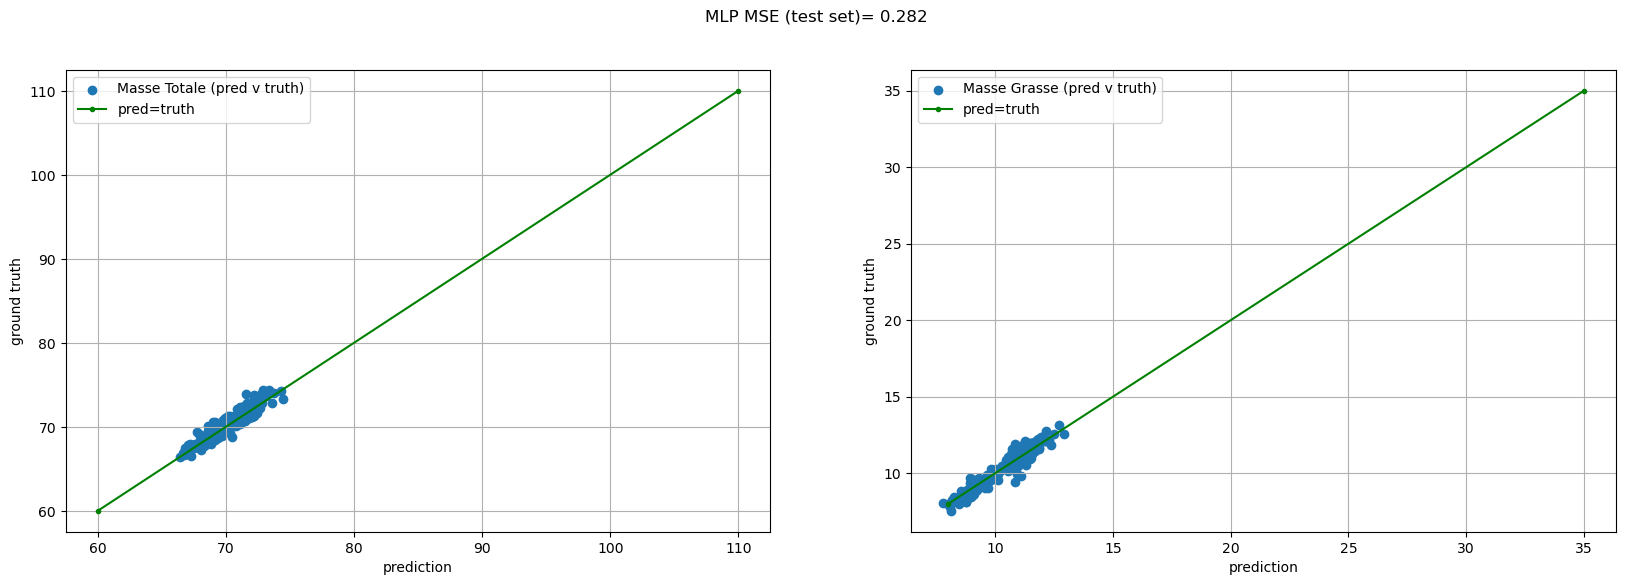

In [35]:
erreur, fig, ax = evaluate(y_pred, y_test, 'MLP ')

### XGBoost

In [36]:
import xgboost as xgb

In [37]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = pd.DataFrame(xgb_model.predict(X_test))

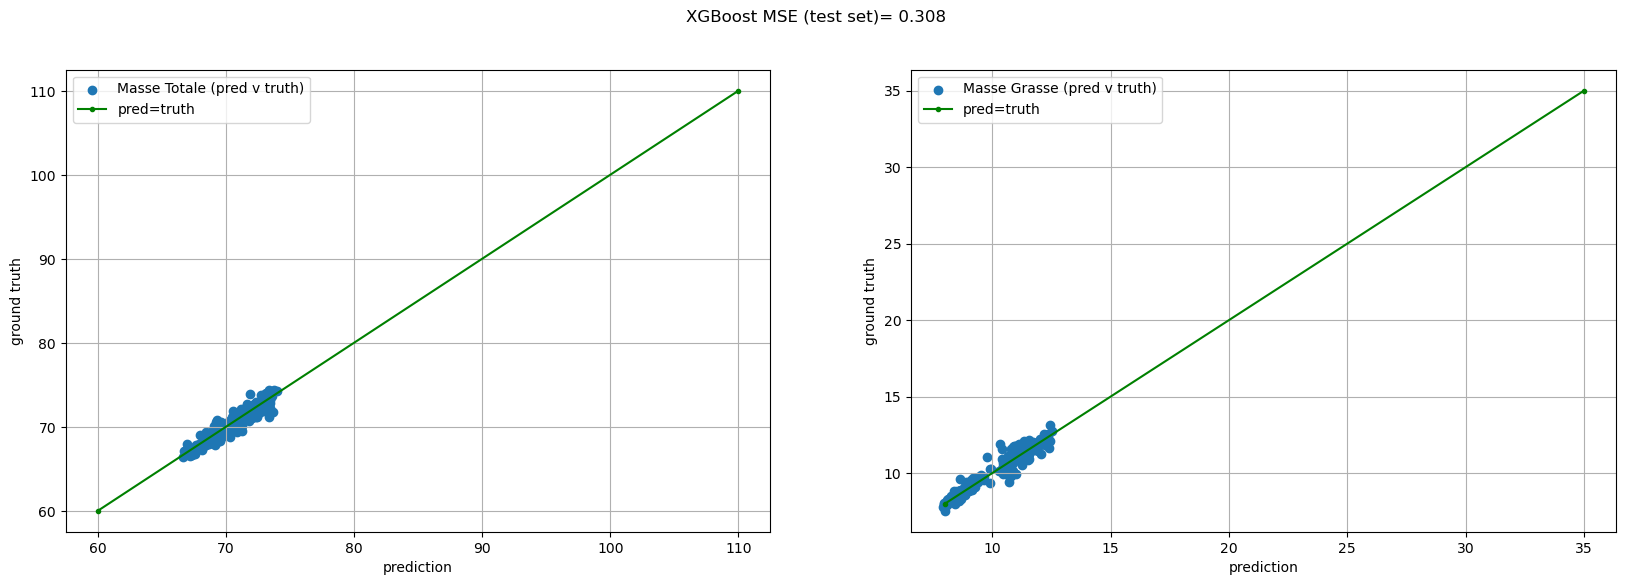

In [38]:
erreur, fig, ax = evaluate(y_pred, y_test, 'XGBoost ')

# Modèles J+p

In [39]:
e = CreateDataset2(ds, past=15, future=7)  # prédiction p jours dans le futur

print(e)

inputs, outputs, df = e.create_dataset()

dataset longueur 958 jours
de 2021-07-01 à 2024-02-20
PAST = 15, FUTUR = 7


In [40]:
# basic test train split

cols_X = [ n for n in df.columns if n[:5]=="input" ]
cols_y = [ n for n in df.columns if n[:6]=="output" ]
X = df[cols_X]
y = df[cols_y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [41]:
X_train

,input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,...,input_62,input_63,input_64,input_65,input_66,input_67,input_68,input_69,input_70,input_71
2021-07-24,1844.6,500.905711,70.750000,9.570000,1932.7,425.214601,70.283333,10.133333,1952.8,0.000000,...,1800.8,0.000000,1798.3,643.996558,1812.1,172.552255,1797.3,0.000000,1800.5,301.784858
2021-09-12,1818.0,0.000000,69.400000,8.372000,1791.4,0.000000,68.966667,8.708333,1809.7,0.000000,...,1806.5,0.000000,1982.9,309.468077,1793.3,0.000000,1783.7,0.000000,1863.0,183.133830
2022-04-21,2130.3,681.880947,68.992308,8.480769,2140.7,748.202635,68.908333,8.562500,2060.2,441.391618,...,2173.8,401.609540,2533.6,734.143572,1899.0,0.000000,2398.2,669.114275,2124.7,440.009372
2023-12-23,1813.7,214.412334,70.765455,11.520909,3355.5,0.000000,72.284545,11.750909,1491.4,427.959107,...,3232.7,147.389877,3369.1,331.326311,1162.2,258.136734,1653.4,461.543067,2395.2,0.000000
2022-07-01,2002.1,451.243793,69.103846,8.360000,1738.6,0.000000,69.600000,9.153333,2056.0,583.897951,...,1934.5,0.000000,1813.7,237.770529,1783.7,196.913697,1874.8,222.016624,1980.4,158.404348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03,1791.0,0.000000,67.583333,8.118333,1894.4,325.769204,67.441667,7.958333,1799.5,0.000000,...,2611.9,679.104742,1824.4,0.000000,2494.4,607.958824,2277.5,0.000000,2257.7,377.243588
2022-04-16,2037.3,519.078633,69.241667,8.781667,2267.7,107.987385,69.670833,8.905000,2169.0,564.237744,...,4263.2,0.000000,2162.6,811.848640,2032.7,823.223675,2238.7,648.585850,1997.0,413.529767
2023-11-30,1654.8,325.957095,70.258750,11.072500,1778.7,0.000000,70.404286,11.120000,1750.0,91.332225,...,1941.0,203.433071,2373.2,0.000000,2218.0,414.438763,1735.3,0.000000,1780.7,203.237325
2022-10-01,3109.7,0.000000,68.740000,9.000000,969.3,519.221728,71.380000,8.960000,1641.4,0.000000,...,1759.1,0.000000,1918.6,460.271776,1951.6,459.656171,2002.0,502.485477,1848.5,338.860009


In [42]:
y_train

,outputs_0,outputs_1,outputs_2,outputs_3,outputs_4,outputs_5,outputs_6,outputs_7,outputs_8,outputs_9,outputs_10,outputs_11,outputs_12,outputs_13
2021-07-24,70.083333,9.056667,70.033333,9.240000,68.962500,9.700000,69.012500,9.532500,68.583333,9.313333,68.716667,9.026667,68.883333,8.886667
2021-09-12,67.945000,8.421000,67.958333,7.685000,68.785714,8.272857,68.128571,8.402857,68.157143,8.450000,68.630000,8.716000,68.420000,8.820000
2022-04-21,69.395833,9.254167,69.979167,9.031667,70.030769,8.996923,69.665385,8.869231,69.884615,9.180000,69.683333,9.015833,69.933333,9.094167
2023-12-23,71.721538,11.783846,72.307500,11.954167,73.006000,12.387000,73.503333,12.770833,73.326667,12.425833,72.683333,12.099167,73.100000,12.794000
2022-07-01,69.962500,9.410833,69.700000,9.160000,70.457692,9.173846,70.062500,9.030833,69.750000,9.408333,69.185714,8.928571,70.370000,9.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03,67.731250,8.162500,67.375000,8.092500,67.037500,8.223750,67.425000,8.250000,67.927778,8.432222,68.350000,8.811250,68.050000,8.512222
2022-04-16,69.726923,8.571538,70.133333,8.801667,71.675000,9.304167,70.250000,9.380000,70.600000,9.553333,69.395833,9.254167,69.979167,9.031667
2023-11-30,70.942000,11.994000,70.697000,11.476000,70.789000,11.640000,71.232000,11.274000,71.701000,11.701000,71.073636,11.648182,71.778000,11.741000
2022-10-01,68.835000,8.639000,70.060000,9.546000,71.270000,9.207000,69.260000,8.925000,68.715000,9.182000,69.170000,9.540000,69.130000,9.414000


### Baseline : régression linéaire simple sur les valeurs historiques

In [43]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

In [44]:
y_pred = lr.predict(X_test)

In [45]:
y_pred = pd.DataFrame(y_pred)
y_pred.iloc[:3,]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,68.746793,8.704708,70.022885,9.080754,69.243611,9.088938,68.659906,8.765716,68.853277,8.661498,69.070386,8.738615,69.118566,8.737042
1,66.785345,7.765169,66.856441,7.594757,66.891560,7.647846,66.953268,7.835685,66.805057,7.813510,66.936655,7.740351,67.361665,7.904477
2,68.364447,8.480502,68.468767,8.463769,68.748497,8.682167,68.685667,8.640138,68.496719,8.424671,68.523848,8.380953,68.793864,8.390378


In [46]:
y_test.iloc[:3,]

,outputs_0,outputs_1,outputs_2,outputs_3,outputs_4,outputs_5,outputs_6,outputs_7,outputs_8,outputs_9,outputs_10,outputs_11,outputs_12,outputs_13
2022-06-08,68.787500,8.634167,70.470000,9.654000,69.330769,8.868462,69.533333,8.514167,68.591667,8.760000,69.217857,8.832857,69.084615,8.829231
2021-09-28,66.433333,7.908333,66.828571,7.840000,66.841667,7.806667,66.591667,7.896667,66.792857,7.887143,67.018000,7.900000,66.783333,7.541667
2022-02-14,68.517857,8.390714,68.483333,8.108667,68.150417,8.220000,68.487500,8.485000,67.906667,8.427333,68.812500,8.142500,67.768750,8.113125


In [47]:
def evaluate2(y_pred, y_test, titre):
    """utility function pour calculer MSE et afficher les prédictions pour une séquence"""
    mse = tf.keras.losses.MeanSquaredError()
    erreur = mse(y_test, y_pred).numpy()
    
    n_rows = len(y_pred.columns)//2 # nombre de valeurs futures à afficher
    max_points = min(50, len(y_pred))
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=2, figsize=(20,6*n_rows))
    
    for i in range(n_rows):

        # ax[i,0].scatter(y_pred.iloc[:,i*2], y_test.iloc[:,i*2], label=f'Masse Totale (pred v truth) à J+{i+1}')
        # ax[i,0].plot([60,110],[60,110], marker='.', color='green', label='pred=truth')
        ax[i,0].plot(y_pred.iloc[-max_points:,i*2].to_numpy()-y_test.iloc[-max_points:,i*2].to_numpy(), label=f'prédiction v truth masse totale à J+{i+1}')
        # ax[i,0].plot(y_test.iloc[-max_points:,i*2].to_numpy(), label=f'ground truth masse totale à J+{i+1}')
        ax[i,0].grid(True)
        ax[i,0].legend()
        # ax[i,0].set_xlabel('prediction')
        # ax[i,0].set_ylabel('ground truth')
        err = mse(y_test.iloc[:,i*2], y_pred.iloc[:,i*2]).numpy()
        ax[i,0].set_title(f'mse = {err:.2f}')

        # ax[i,1].scatter(y_pred.iloc[:,i*2+1], y_test.iloc[:,i*2+1], label=f'Masse Grasse (pred v truth) à J+{i+1}')
        # ax[i,1].plot([8,35],[8,35], marker='.', color='green', label='pred=truth')
        ax[i,1].plot(y_pred.iloc[-max_points:,i*2+1].to_numpy() - y_test.iloc[-max_points:,i*2+1].to_numpy(), label=f'prédiction v truth masse grasse à J+{i+1}')
        # ax[i,1].plot(y_test.iloc[-max_points:,i*2+1].to_numpy(), label=f'ground truth masse grasse à J+{i+1}')
        ax[i,1].grid(True)
        ax[i,1].legend()
        # ax[i,1].set_xlabel('prediction')
        # ax[i,1].set_ylabel('ground truth')
        err = mse(y_test.iloc[:,i*2+1], y_pred.iloc[:,i*2+1]).numpy()
        ax[i,1].set_title(f'mse = {err:.2f}')

    title = titre + f'MSE (test set)= {erreur:.3f}'
    fig.suptitle(title)
    
    return erreur, fig, ax

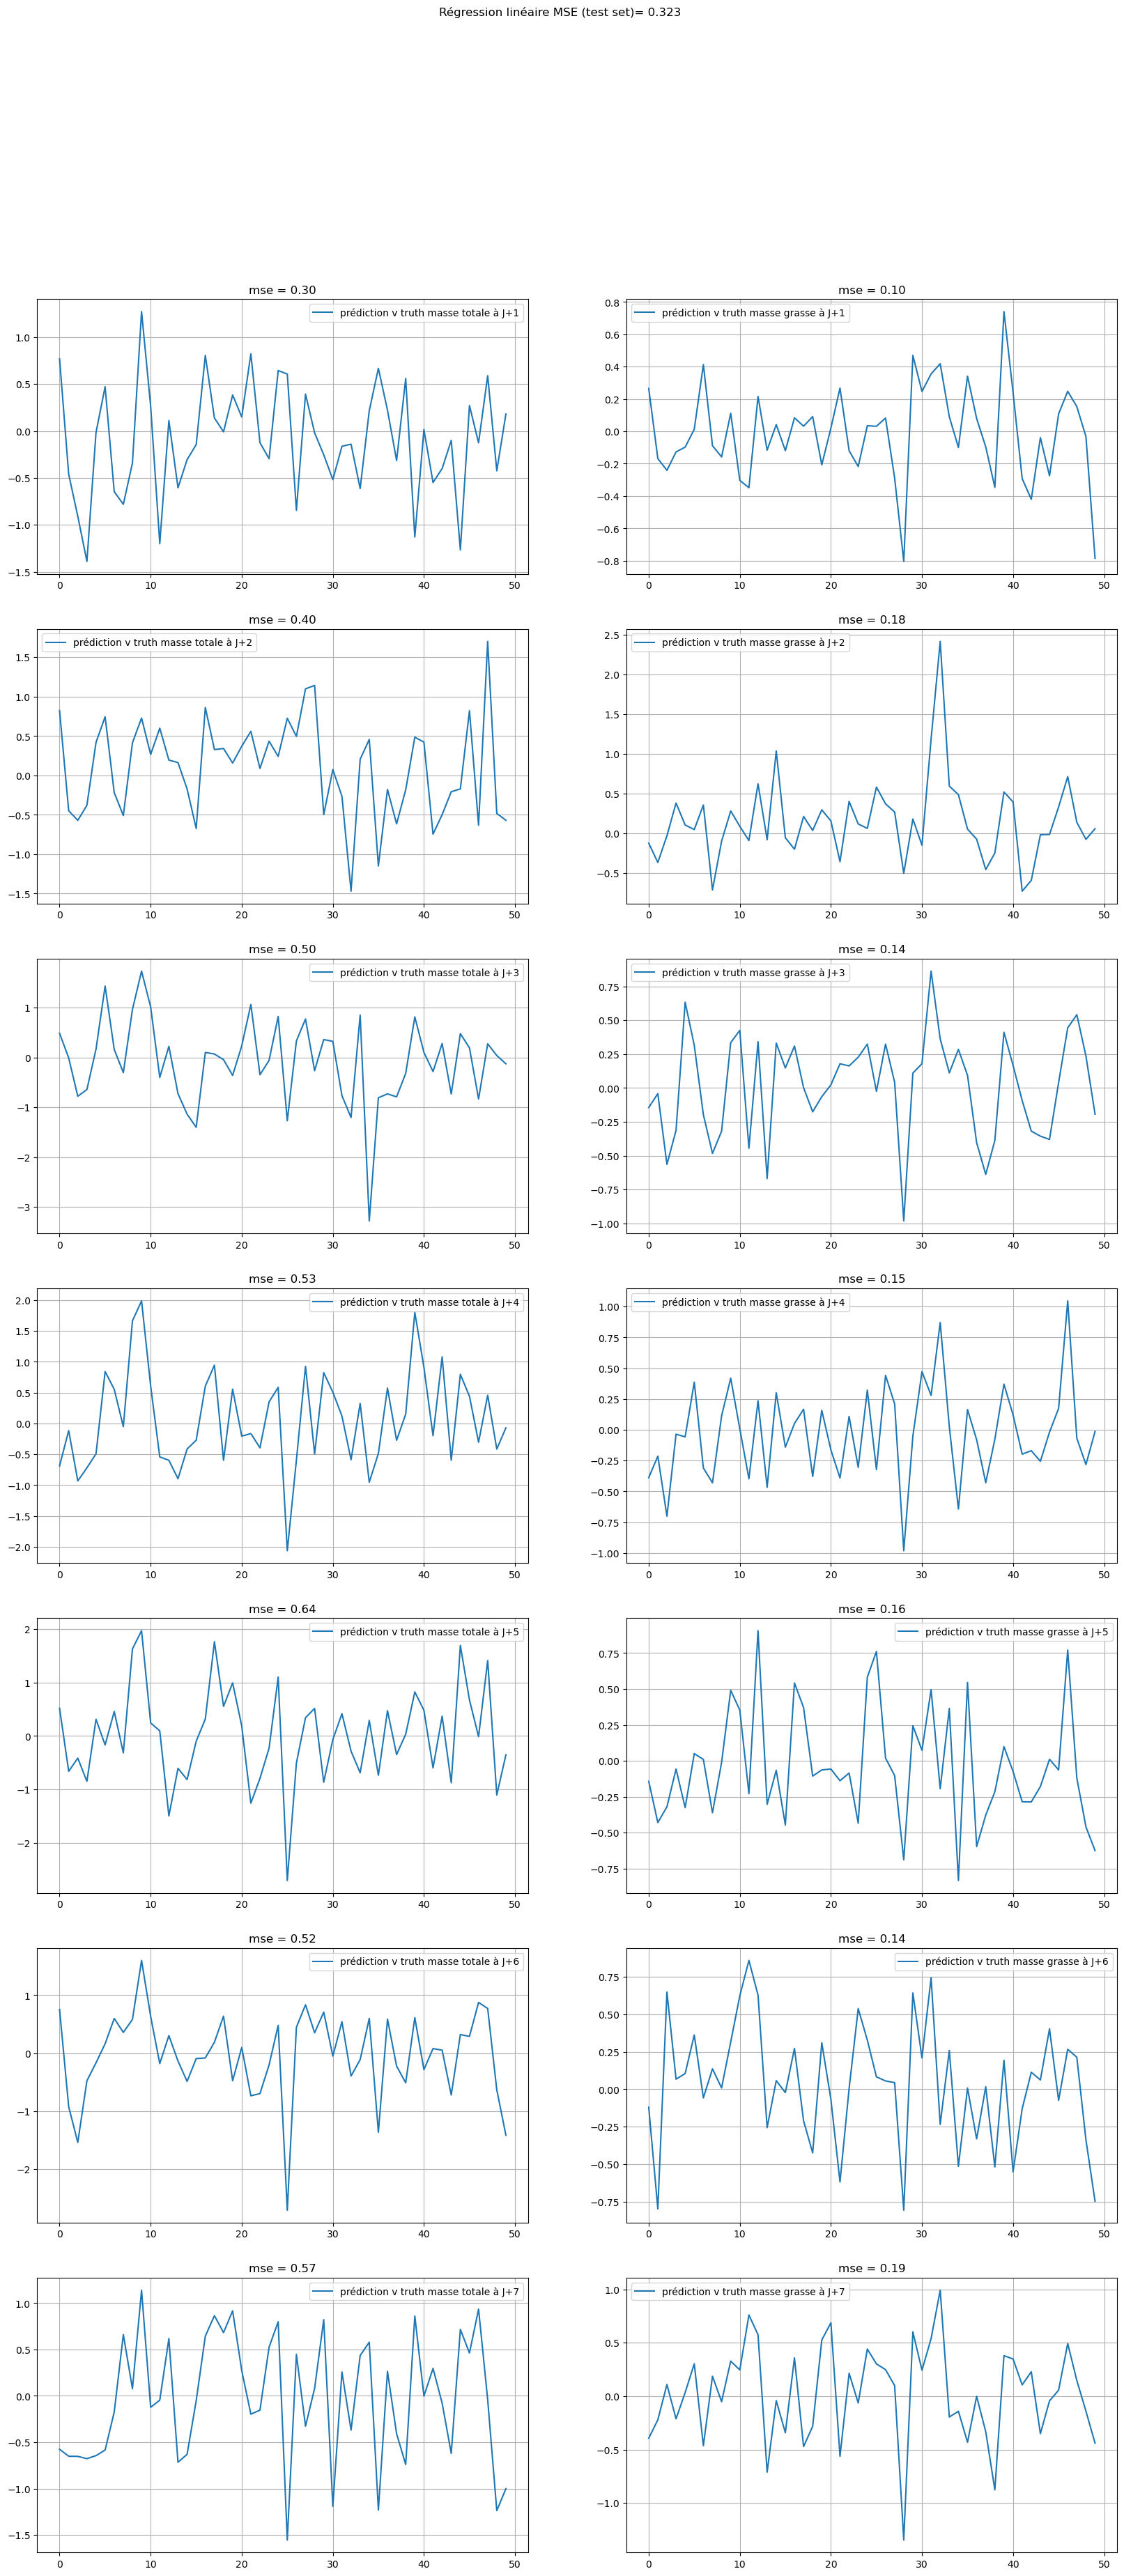

In [48]:
erreur, fig, ax = evaluate2(y_pred, y_test, titre=f'Régression linéaire ')

### MLP

In [49]:
n_features = X_train.shape[1]
n_outputs = y_train.shape[1]

n_units = 256

In [50]:
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [51]:
mlp = tf.keras.models.Sequential(
    [ tf.keras.layers.Input(shape=(n_features,)),
     tf.keras.layers.Dense(units=n_units, activation='relu'),
     tf.keras.layers.Dense(units=n_units, activation='relu'),
     tf.keras.layers.Dense(units=n_units, activation='relu'),
     tf.keras.layers.Dense(units=n_outputs, activation='linear')]
)

In [52]:
mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               18688     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 14)                3598      
                                                                 
Total params: 153,870
Trainable params: 153,870
Non-trainable params: 0
_________________________________________________________________


In [53]:
mlp.compile(
    optimizer='rmsprop',
    loss = tf.keras.losses.MeanSquaredError()
)

cb1 = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)

In [54]:
history = mlp.fit(
    X_train_scaled, y_train_scaled,
    epochs=1000,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks = [cb1]
)

Epoch 1/1000
24/24 [==============================] - 6s 110ms/step - loss: 0.2607 - val_loss: 0.1810
Epoch 2/1000
24/24 [==============================] - 2s 68ms/step - loss: 0.1337 - val_loss: 0.1718
Epoch 3/1000
24/24 [==============================] - 2s 71ms/step - loss: 0.1131 - val_loss: 0.1948
Epoch 4/1000
24/24 [==============================] - 2s 67ms/step - loss: 0.0964 - val_loss: 0.1369
Epoch 5/1000
24/24 [==============================] - 2s 71ms/step - loss: 0.0911 - val_loss: 0.1500
Epoch 6/1000
24/24 [==============================] - 1s 63ms/step - loss: 0.0844 - val_loss: 0.2230
Epoch 7/1000
24/24 [==============================] - 2s 70ms/step - loss: 0.0740 - val_loss: 0.1329
Epoch 8/1000
24/24 [==============================] - 2s 75ms/step - loss: 0.0694 - val_loss: 0.1326
Epoch 9/1000
24/24 [==============================] - 2s 77ms/step - loss: 0.0668 - val_loss: 0.1215
Epoch 10/1000
24/24 [==============================] - 1s 58ms/step - loss: 0.0619 - val_l

In [55]:
y_pred_scaled = mlp.predict(X_test_scaled)
y_pred = pd.DataFrame(y_scaler.inverse_transform(y_pred_scaled))

6/6 [==============================] - 1s 19ms/step


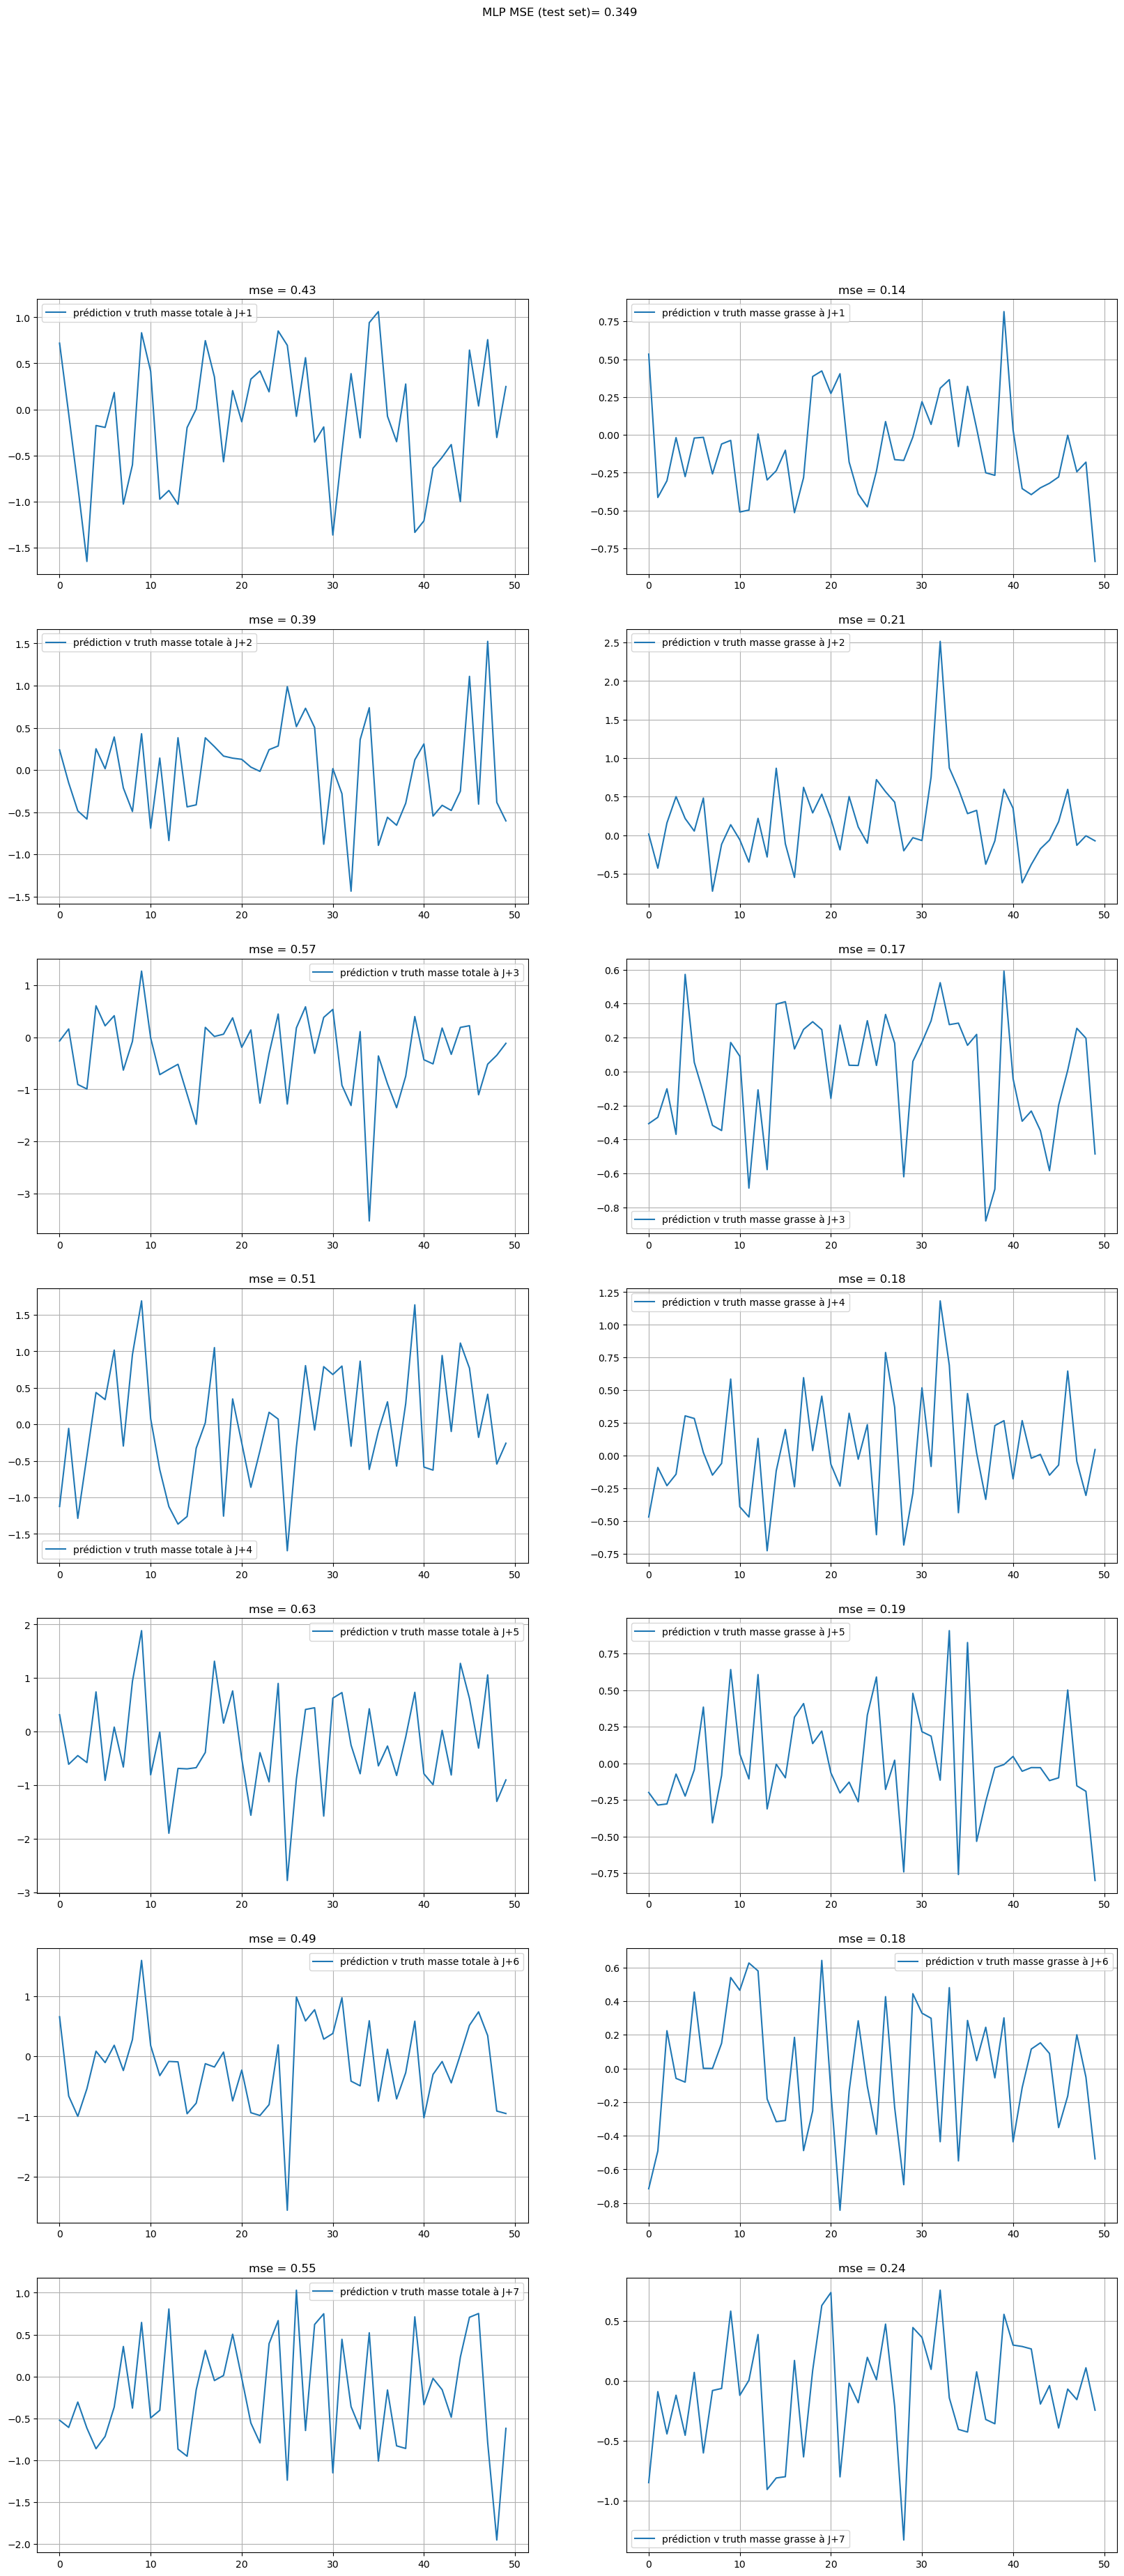

In [56]:
erreur, fig, ax = evaluate2(y_pred, y_test, titre=f'MLP ')